In [164]:
import numpy as np

import scipy.constants as cs
from scipy.optimize import curve_fit
import scipy.ndimage as ndimage

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import tqdm
import scipy.io

import csv

In [167]:
data = scipy.io.loadmat('real data/jun1_run9.mat')
stack = data['stack']

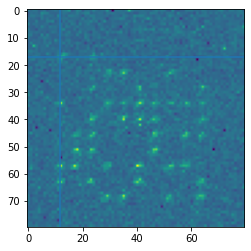

In [168]:
plt.imshow(stack[1])
plt.axvline(11.77)
plt.axhline(17.032)

20


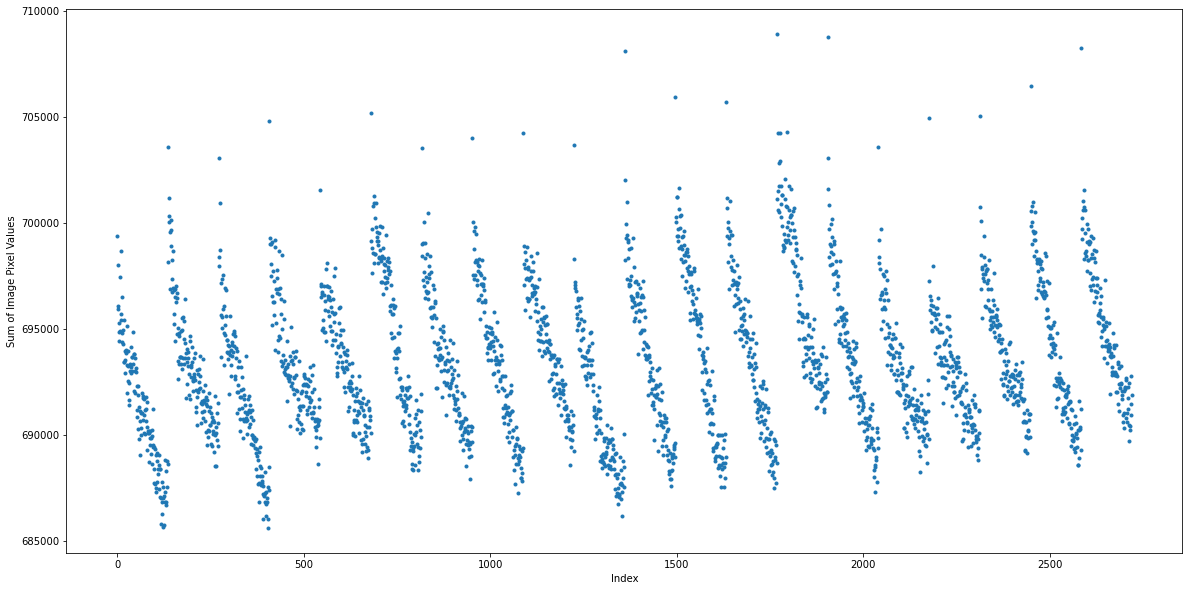

In [169]:
pixels = np.sum(stack, axis=(1, 2))
n_per_loop = 136
n_loops = stack.shape[0] // n_per_loop

print(n_loops)

plt.figure(figsize=(20, 10))
plt.plot(pixels, '.')
#for i in range(20):
#    plt.axvline(136 * i, color='r', linestyle='--')

plt.xlabel("Index")
plt.ylabel("Sum of Image Pixel Values")
plt.show()

Seems that every 136 images we reset the lattice.

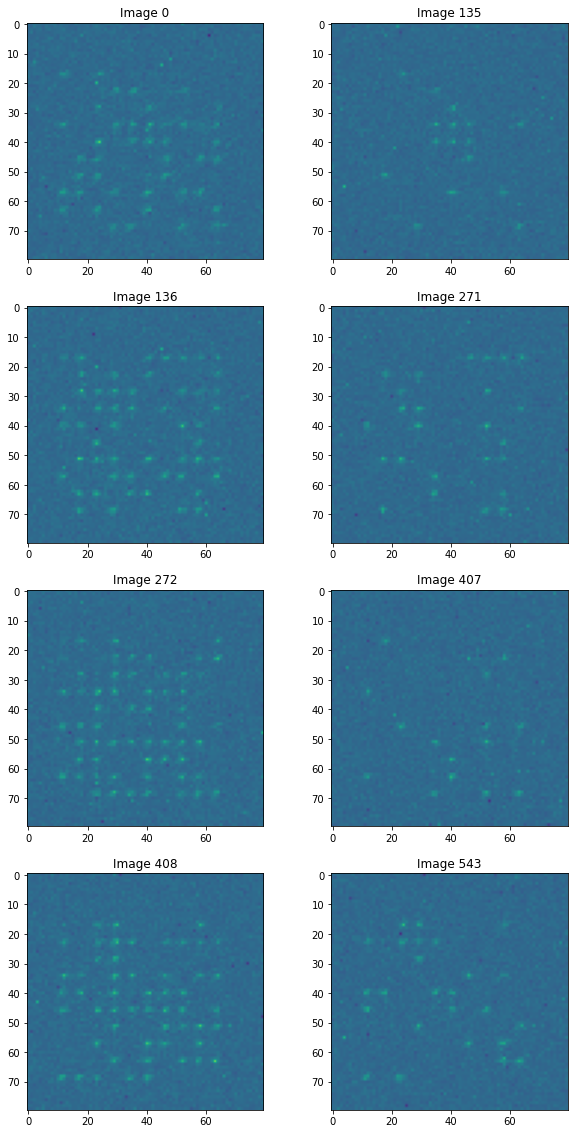

In [170]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
min_val, max_val = stack.min(), stack.max()

for i in range(4):
    axs[i, 0].imshow(stack[136 * i], vmin=min_val, vmax=max_val)
    axs[i, 1].imshow(stack[136 * (i + 1) - 1], vmin=min_val, vmax=max_val)
    axs[i, 0].set_title(f"Image {136 * i}")
    axs[i, 1].set_title(f"Image {136 * (i + 1) - 1}")

(14, 0)


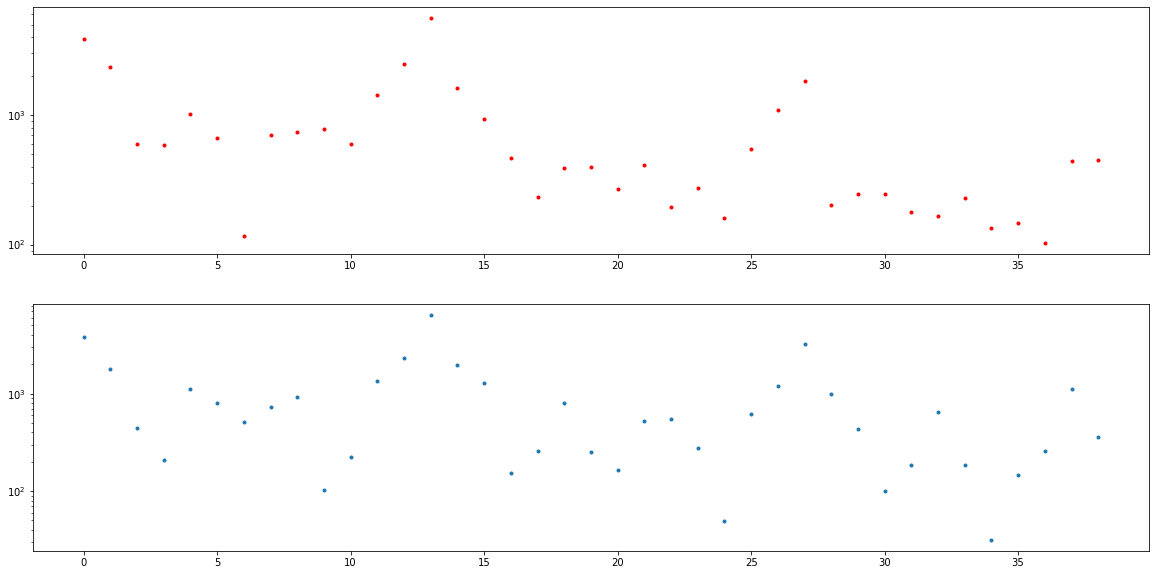

In [171]:
avg_img = np.mean(stack, axis=0) - np.mean(stack)
spectral_content = np.fft.fft2(avg_img)
spectral_content = spectral_content[:spectral_content.shape[0] // 2, :spectral_content.shape[1] // 2]

print(np.unravel_index(spectral_content.argmax(), spectral_content.shape))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

axs[0].plot(np.absolute(spectral_content[0, 1:]), 'r.')
axs[0].set_yscale('log')
axs[1].plot(np.absolute(spectral_content[1:, 0]), '.')
axs[1].set_yscale('log')

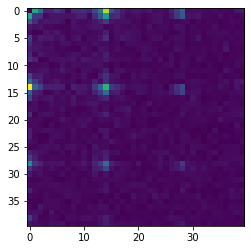

6413.514809855284


In [172]:
plt.imshow(np.absolute(spectral_content))
plt.show()

print(np.absolute(spectral_content[14, 0]))

In [173]:
def periodic_gaussian(n_sites):
    def helper(x, lattice_constant, lattice_offset, std, scaling, offset):
        ans = 0
        for i in range(n_sites):
            ans += np.exp(-((x - i * lattice_constant - lattice_offset) / std) ** 2 / 2)
        return scaling * ans + offset
    return helper

def lattice_characteristics(data, lattice_shape):
    #TODO: Split into two functions for the lattice constant and the lattice offset
    xdata = np.sum(data, axis=(0, 1)) / (data.shape[0] * data.shape[2])
    ydata = np.sum(data, axis=(0, 2)) / (data.shape[0] * data.shape[1])
    guess = [data.shape[1] / lattice_shape[0], 0, data.shape[1] / lattice_shape[0], xdata.max() - xdata.min(), ydata.min()]
    xparams, xerr = curve_fit(periodic_gaussian(lattice_shape[0]), np.arange(len(xdata)), xdata, p0=guess)
    yparams, yerr = curve_fit(periodic_gaussian(lattice_shape[1]), np.arange(len(ydata)), ydata, p0=guess)
    return np.array([xparams[0], yparams[0]]), np.array([xparams[1], yparams[1]])

def background_statistics(data, lattice_shape, lattice_constant, lattice_offset):
    bottom_buf = int(np.rint(lattice_offset[0] - lattice_constant[0]))
    left_buf = int(np.rint(lattice_offset[1] - lattice_constant[1]))
    top_buf = int(np.rint(lattice_offset[0] + lattice_shape[0] *  lattice_constant[0]))
    right_buf = int(np.rint(lattice_offset[1] + lattice_shape[1] *  lattice_constant[1]))
    bottom, left = data[:, :right_buf, :bottom_buf], data[:, right_buf:, :top_buf]
    top, right = data[:, left_buf:, top_buf:], data[:, :left_buf, bottom_buf:]
    background = np.concatenate((bottom, left, top, right), axis=None)
    return background.mean(), background.std()

def dark_statistics(data, occupancies, lattice_shape, lattice_constant, lattice_offset):
    return

def crop(data, x, y, border):
    return data[:, int(np.rint(x - border)): int(np.rint(x + border)),
                int(np.rint(y - border)): int(np.rint(y + border))]

def crop_sites(n, data, lattice_constant, lattice_offset, lattice_shape):
    border = np.rint(n / 2 * lattice_constant.mean())
    lattice_constant = np.array([[lattice_constant[0], 0], [0, lattice_constant[1]]])
    lattice_offset = np.tile(lattice_offset, (np.prod(lattice_shape), 1))
    sites = np.array([np.array([i // lattice_shape[0], i - lattice_shape[0] * (i // lattice_shape[0])]) 
                          for i in range(np.prod(lattice_shape))])
    lattice_sites = np.matmul(sites, lattice_constant) + lattice_offset
    return np.concatenate(tuple([crop(data, site[0], site[1], border) for site in lattice_sites]))


(272000, 18, 18)


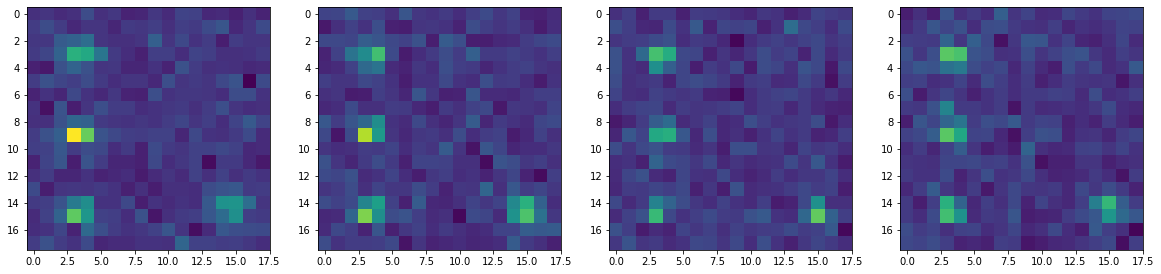

In [174]:
lattice_constant, lattice_offset = lattice_characteristics(stack, np.array([10, 10]))
background_statistics(stack, np.array([10, 10]), lattice_constant, lattice_offset)
images = crop_sites(3, stack, lattice_constant, lattice_offset, np.array([10, 10]))
print(images.shape)
images = np.reshape(images, (100, -1, 18, 18))

i = np.random.randint(0, images.shape[0])
j = np.random.randint(0, images.shape[1])

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

combined = np.concatenate((images[i, j], images[i, j + 3]))
min_val, max_val = combined.min(), combined.max()

for n in range(4):
    axs[n].imshow(images[i, j + n], vmin=min_val, vmax=max_val)
plt.show()

In [175]:
images = crop_sites(1, stack, lattice_constant, lattice_offset, np.array([10, 10]))
images = np.reshape(images, (100, -1, 6, 6))
print(images.shape)

(100, 2720, 6, 6)


# Single Site Aggregate Pixels -- Red Lines Mark New Loop

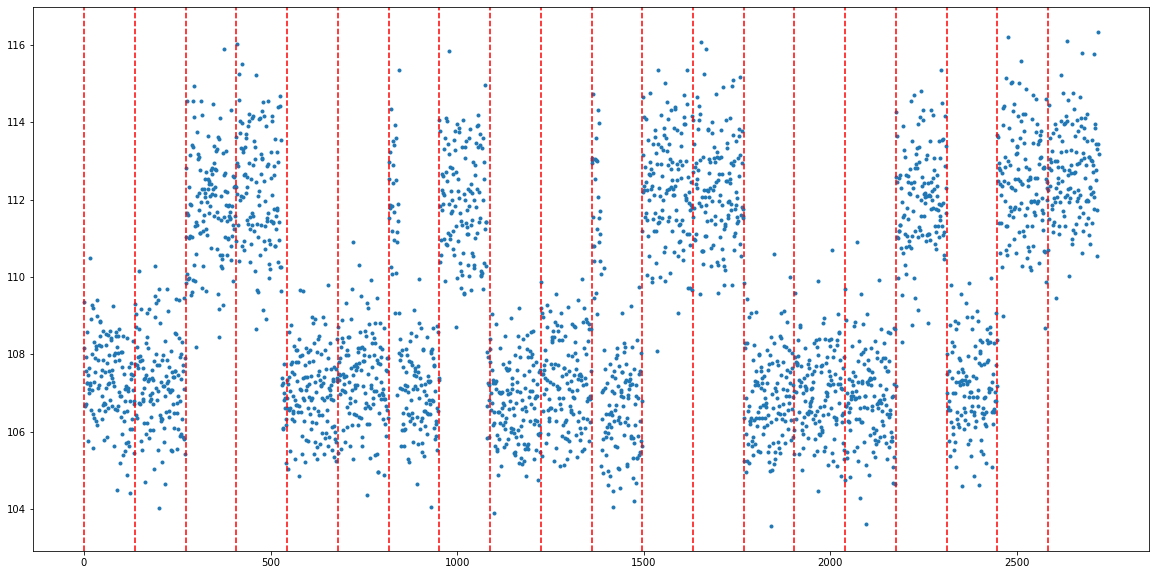

In [177]:
i = np.random.randint(0, images.shape[0])

plt.figure(figsize=(20, 10))
plt.plot(np.mean(images[i], axis=(1, 2)), '.')
for i in range(20):
    plt.axvline(136 * i, color='r', linestyle='--')